# Deviation from Median Center

This script identifies the median centers of DNAInfo neighborhoods, according to the centroids of neighborhood drawings. The spatial deviation of drawing centoids from these median centers is computed for each neighborhood according to their standard deviation from the median center, and also the mean absolute deviation, which is less sensitive to outlying values and hence more robust than standard deviation.

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import scipy.stats as sp
import Pycluster as pc

%matplotlib inline

In [2]:
# DNAInfo Data
ny_data = r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC_Analysis_wgs84.geojson'
#ny_data = r'C:\Users\Dan\OneDrive\Draw-Your-Neighborhood-master\NYC_raw_wgs84.geojson'
ny_nhoods = gpd.read_file(ny_data)

# Set the crs of the input geojson to WGS84
ny_nhoods.crs = {'init': 'epsg:4326'}

# Tranform to projected coordinate system - EPSG:32118 - New York Long Island, NAD83-based projection in metres.
ny_nhoods = ny_nhoods.to_crs({'init':'epsg:32118'})

ny_nhoods.head()

,geometry,neighborhoodLive,nhood,otherNeighborhood,shapeID,yearsLived
0,"POLYGON ((311834.6421283125 77460.83003323362,...",Allerton,Allerton,,259,2
1,"POLYGON ((311305.0904452928 78317.74772848203,...",Allerton,Allerton,,298,0
2,"POLYGON ((311189.369271409 78288.7412320913, 3...",Allerton,Allerton,,5964,2
3,"POLYGON ((311199.2696228614 77331.72545915398,...",Allerton,Allerton,,59957,15
4,"POLYGON ((311137.8304619553 78879.66082988337,...",Allerton,Allerton,,61660,1


In [37]:
# Add Centroids, Area, Shape fields to data

# Calculate the geometric centroid of each record
ny_nhoods['centroid'] = ny_nhoods['geometry'].centroid

# Calculate the area of each drawing in square km
ny_nhoods['area'] = ny_nhoods['geometry'].area/1000000

# Calculate the perimeter of each drawing
ny_nhoods['perimeter'] = ny_nhoods['geometry'].length

In [4]:
# Work out neighborhood median centers based on drawing centroids

# Group the data
ny_grp = ny_nhoods.groupby('nhood')

# Now calulate 
n_hood_centroids = {}
count = 0
for nid, data in ny_grp:
    centroids = []
    for row in data.iterrows():
        centroids.append(np.array(row[1]['centroid']))
    ncenter, nmask = pc.clustercentroids(centroids,method='m')
    n_hood_centroids[count] = [nid,shapely.geometry.Point(ncenter[0]),len(data)]
    count+=1
    
# Finally, put the median center information and counts of drawings into a new geopandas dataframe
n_centroids = gpd.GeoDataFrame(n_hood_centroids).transpose()
# Name the columns
n_centroids.columns = ["neighborhood","geometry","count"]
# Add a rank column based upon the number of drawings
n_centroids['rank'] = n_centroids['count'].rank(ascending=False)
# Set the CRS of n-centroids
n_centroids.crs = {'init': 'epsg:32118'}

n_centroids.head()

,neighborhood,geometry,count,rank
0,Allerton,POINT (311643.6932491333 77597.82904214269),104,84.5
1,Alphabet City,POINT (301709.2279281036 62002.55728907162),140,68.0
2,Annadale,POINT (284646.1229115428 41711.41527360405),94,88.5
3,Arden Heights,POINT (284048.4499701513 43075.44375345457),77,106.5
4,Arrochar,POINT (293869.7801887682 47913.39909703079),40,162.0


In [5]:
# Work out euclidean distance to neighborhood median center from each drawings' centroid
ny_nhoods['dcentroid'] = ny_nhoods.apply(lambda x: x['centroid'].distance(n_centroids[n_centroids['neighborhood'] == x['nhood']]['geometry'].values[0]), axis=1)

In [6]:
# Let's add borough data so that we can aggregate by NYC borough

# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

# Do a spatial join of nyc on n_centroids (point in polygon)
n_centroids = gpd.sjoin(n_centroids, nyc, how="left", op='within')

# Now append the BoroName to the Drawings based on the neighborhood.
ny_nhoods = ny_nhoods.merge(n_centroids.ix[:,['neighborhood','BoroName']],left_on='nhood',right_on='neighborhood')
del ny_nhoods['neighborhood']

In [44]:
# Standard Deviation and Mean Absolute Deviation (MAD) of Area and Shape by Neighborhood

# function for MAD
mad = lambda x: np.mean(np.abs(x - np.mean(x)))

# function for standard deviation-like statistic for centroid distance
std_l = lambda x: np.sqrt(np.sum(np.power(x,2))/x.count())

# Group the data by borough then by neighborhood
ny_b_grp = ny_nhoods.groupby(['BoroName','nhood'])

stats = ny_b_grp.agg({'area': [np.mean,np.median,np.std,mad], 'perimeter': [np.mean,np.median,np.std,mad], 'dcentroid':[std_l,np.mean,len]})

# Relabel columns
stats.columns.set_levels([u'mad', u'mean', u'median', u'std',u'n'], 1, inplace=True)
stats.columns.set_labels([1,2,3,0,3,0,4,1,2,3,0],1,inplace =True)

stats.head()

perimeter                                         \
                               mean       median          std          mad   
BoroName nhood                                                               
Bronx    Allerton       6695.139722  6192.772054  4626.677864  3396.423472   
         Baychester     9619.081789  6003.954499  7950.248164  5023.053699   
         Bedford Park   4579.600399  4872.711867  1642.996263  1277.490585   
         Belmont        4773.933190  3964.052064  3126.865563  2022.499497   
         Castle Hill    6830.953670  6361.213018  2492.190555  1965.061048   

                          dcentroid                          area            \
                                std          mad      n      mean    median   
BoroName nhood                                                                
Bronx    Allerton       2841.776547  1339.342260  104.0  3.502612  2.162806   
         Baychester     2308.990305  1378.586616   17.0  6.746487  2.262279   
         Bedford Park    435.401901   326.537281   46.0  1.218858  1.109304   
         Belmont         601.258227   382.958167   49.0  1.764708  0.855709   
         Castle Hill     546.301940   426.145604   35.0  2.212625  1.873510   

                                             
                              std       mad  
BoroName nhood                               
Bronx    Allerton        5.192136  3.101870  
         Baychester     11.824314  6.725278  
         Bedford Park    0.832566  0.597649  
         Belmont         3.083846  1.609891  
         Castle Hill     1.747985  1.201028

In [70]:
boros = ['Manhattan','Brooklyn','Queens','Bronx','Staten Island']

for boro in boros:
    print boro
    print "Number of neighborhoods:",stats.ix[boro].count()[0]
    print stats.ix[boro].mean()
    print "Spearman's Rank:", sp.spearmanr(stats.ix[boro]['area']['median'],stats.ix[boro]['dcentroid']['mad'])[0],sp.spearmanr(stats.ix[boro]['area']['median'],stats.ix[boro]['dcentroid']['mad'])[1]

print "Overall"
print "Total number of neighborhoods:",stats.count()[0]
print stats.mean()
print "Spearman's Rank:", sp.spearmanr(stats['area']['median'],stats['dcentroid']['mad'])[0],sp.spearmanr(stats['area']['median'],stats['dcentroid']['mad'])[1]

Manhattan
Number of neighborhoods: 60
perimeter  mean      4216.136905
           median    4057.467338
           std       1362.215761
           mad        967.132873
dcentroid  std        427.520580
           mad        255.657029
           n          252.000000
area       mean         1.201386
           median       1.075424
           std          0.788229
           mad          0.515341
dtype: float64
Spearman's Rank: 0.660127813281 9.59522431732e-09
Brooklyn
Number of neighborhoods: 58
perimeter  mean      6523.799206
           median    6219.808741
           std       2305.959737
           mad       1589.598942
dcentroid  std        800.599001
           mad        420.997494
           n          259.224138
area       mean         2.788992
           median       2.366135
           std          2.223984
           mad          1.308865
dtype: float64
Spearman's Rank: 0.589959703467 1.09639406228e-06
Queens
Number of neighborhoods: 66
perimeter  mean      8093.260548
 

In [48]:
#export the stats table to excel for formatting as supplementary table 1
stats.to_excel('supplementary_table_1.xlsx', sheet_name='Sheet1')

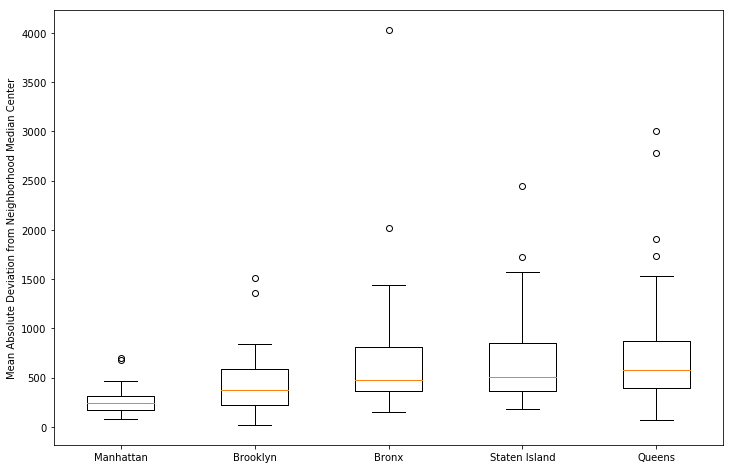

In [100]:
# make a boxplot for borough centroid deviations.
bp = []
boros = ['Manhattan','Brooklyn','Bronx','Staten Island','Queens']
for boro in boros:
    bp.append(stats.ix[boro]['dcentroid']['mad'])

fig,ax = plt.subplots(1,figsize=(12,8))
ax.boxplot(bp)
plt.xticks(range(1,6),boros)
ax.set_ylabel("Mean Absolute Deviation from Neighborhood Median Center")
plt.savefig('Boxplot.png',dpi=300)